<div>
    <h1>Table Of Content</h1>
    <ul class="table_of_contents" style="list-style:none;">
        <li>
            <a href="#Beginner" style="padding:5px; font-size: 20px;"><b>Beginner<b></a>
            <ul style="list-style:none;">
                <li><a href="#b_linear_int" style="padding:5px; font-size: 17px;">Linear Interpolation</a></li>
                <li><a href="#b_train_zone" style="padding:5px; font-size: 17px;">Training Zones</a></li>
            </ul>
        </li>
        <li>
            <a href="#Intermediate" style="padding:5px; font-size: 20px;"><b>Intermediate<b></a>
            <ul style="list-style:none;">
                <li><a href="#i_load_data" style="padding:5px; font-size: 17px;">Load Data</a></li>
                <li><a href="#i_filter_data" style="padding:5px; font-size: 17px;">Filter Data</a></li>
                <li><a href="#i_linear_int" style="padding:5px; font-size: 17px;">Linear Interpolation</a></li>
            </ul>
        </li>
        <li>
            <a href="#Advanced" style="padding:5px; font-size: 20px;"><b>Advanced<b></a>
            <ul style="list-style:none;">
                <li><a href="#a_exponential_fit_via_lm" style="padding:5px; font-size: 17px;">exponential fit via lm</a></li>
                <li><a href="#a_exponential_fit_with_scipy" style="padding:5px; font-size: 17px;">exponential fit with scipy</a></li>
                <li><a href="#a_ipywidgets" style="padding:5px; font-size: 17px;">ipywidgets</a></li>
                <li><a href="#a_cubic_fit" style="padding:5px; font-size: 17px;">cubic fit</a></li>
            </ul>
        </li>        
    </ul>
</div>

# Lactate Thresholds
In this notebook we explain how you can analyze your data from an incremental exercise test. We show you, how to obtain submaximal lactate thresholds and how to derive training recommendations, eg velocity and heart rate zones. We first give you some information about the theoretical background. Then, we start with a beginner-friendly example. We progress with a more general approach on an intermediate level. Lastly, we show you more advanced techniques that lead us to different threshold concepts (there are many of them!).
Let´s import some basic libraries:

In [1]:
import numpy as np                # linear algebra
import pandas as pd               # data processing
import matplotlib.pyplot as plt   # plotting

## Theoretical Background
...

<a id="Beginner"></a>
<h1>First example: Beginner Level</h1>

We got data from an incremental test on a treadmill, starting at 2 m/s and increments by 0.4 m/s per stage; stage length is 4 min. We measured blood lactate and heart rate at the end of each stage:

In [3]:
# incremental test data
stage = [2, 2.4, 2.8, 3.2, 3.6, 4.0, 4.4]            # velocity in m/s
lactate = [1.8, 1.75, 1.98, 2.54, 3.46, 6.38, 14.37] # lactate in mmol/l
HR = [95, 108, 131, 152, 174, 185, 192]              # heart rate in bpm

<a id="b_linear_int"></a>
## Fixed Threshold - Linear Interpolation
We want to know the speed at a fixed threshold of 4 mmol. You could obtain that threshold graphically by drawing a vertical line at 4 mmol in this simple line plot:

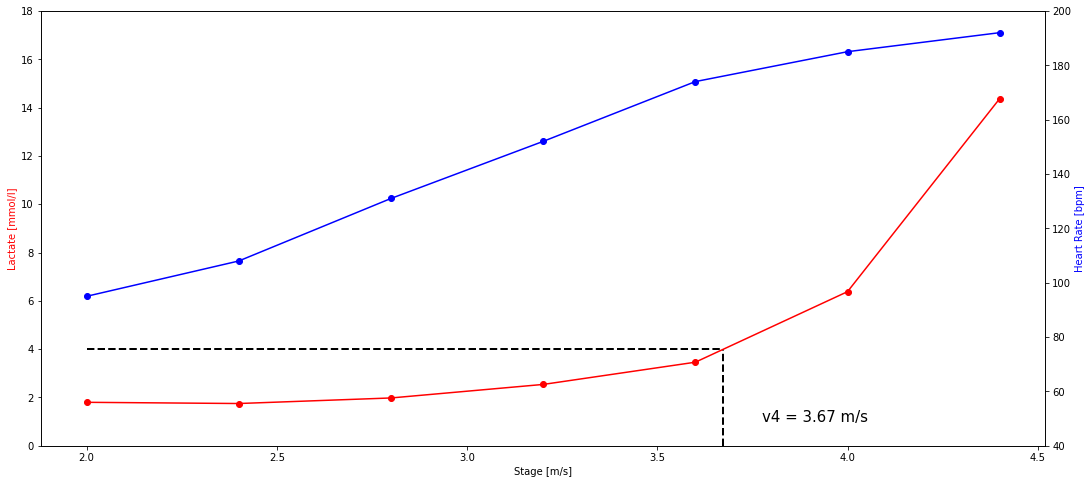

In [4]:
from pylab import rcParams

# change size of all figures in this notebook
rcParams['figure.figsize'] = 18, 8

def plot_increment(stage,lactate,HR):
    # create plot with two y-axes
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(stage, lactate, 'r-o')
    ax2.plot(stage, HR, 'b-o')

    # set labels
    ax1.set_xlabel('Stage [m/s]')
    ax1.set_ylabel('Lactate [mmol/l]', color='r')
    ax2.set_ylabel('Heart Rate [bpm]', color='b')

    # adjust axes limits for better visualisation in this example
    ax1.set_ylim(0, 18)
    ax2.set_ylim(40, 200)
    
    return ax1

    
ax1 = plot_increment(stage,lactate,HR)  

# draw vertical line at 4 mmol

v4 = np.interp(4, lactate, stage)

ax1.vlines(x=v4,ymin=0,ymax=4,linewidth=2, color='black', linestyle='dashed')
ax1.hlines(y=4, xmin=2, xmax=v4, linewidth=2, color='black',linestyle='dashed')

# add label
ax1.text(v4 + 0.1, 1, f"v4 = {round(v4,2)} m/s", fontsize=15)

plt.show()

### Linear interpolation
You can easily do the maths using two points on the lactate curve: the one before and the one after 4 mmol. And you need the corresponding speed. You can use the following formula that is just derived by linear interpolation, which is just the rule of three (German: Dreisatz). Starting from the point before 4 mmol you want to increase the corresponding speed value as much as you need to increase your lactate value proportionally. For that, you multiply the slope $ \frac{\Delta{v}}{\Delta{L}} = \frac{v_2 - v_1}{L_2 - L_1} $ between the two points with the amount of Lactate $ (4 - L_1) $ you need to go up and add this to the speed of the lower stage $ v_1 $:

$$ v_{4mmol} = v_1 + (4 - L_1) * \frac{v_2 - v_1}{L_2 - L_1}  $$

![Linear Interpolation](https://matthew-brett.github.io/teaching/_images/linear_interpolation-1.png)

from: https://matthew-brett.github.io/teaching/_images/linear_interpolation-1.png

By observing the graph above, we can see, that the threshold is somewhere between the 5th and 6th datapoint. Since we start counting from 0, the datapoints are:<br> <code>lactate[4]</code> to <code>lactate[5]</code> and <br>  <code>stage[4]</code> to <code>stage[5]</code>

In [5]:
L1 = lactate [4]
L2 = lactate [5]
v1 = stage [4]
v2 = stage [5]

v4 = v1 + (4 - L1) *  (v2 - v1) / (L2- L1)
print(f"Velocity at 4 mmol: {round(v4,2)} m/s")

Velocity at 4 mmol: 3.67 m/s


### Interpolation with numpy
If you like, you can save some lines of code by inserting eg `lactate [4]` into the formula directly. You could do the math with paper and pencil or in your head or in a spreadsheet. However, we actually use Python and - of course - there is a built-in function for linear interpolation in the`numpy` package:

In [6]:
np.interp(4, lactate, stage)

3.673972602739726

<a id="b_train_zone"></a>
### Training Zones
We can even pass multiple values to this function, which makes our lives easier to calculate training zones, eg the velocities or heart rates at 2 and 4 mmol building a 3 zone model:

In [7]:
np.interp([2, 4], lactate, stage)

array([2.81428571, 3.6739726 ])

In [8]:
np.interp([2, 4], lactate, HR)

array([131.75      , 176.03424658])

There are several possible ways to derive training zones. One way would be the 3-zone model using two physiological ancherpoints, an aerobic and an anaerobic threshold. Another solution would be to anchor the training zones solely on the performance at the anaerobic threshold. Hence, we will use our $ v_4 $ and calculate the thresholds based on percentages. We will use <60%, 75%, 90%, 100% and 110% as thresholds to derive 5 zones.

In [9]:
Z=np.array([.6, .75, .9, 1, 1.1])
vZ = v4*Z
vZ

array([2.20438356, 2.75547945, 3.30657534, 3.6739726 , 4.04136986])

If you want to know the corresponding heart rate, you could, again, simply draw a vertical line and read off the value in the heart rate curve. Mathematically, it´s linear interpolation again. We pass our calculated velocity zones `vZ` to the `np.interp` function and get our result in one line.

In [10]:
np.interp(vZ, stage, HR)

array([101.64246575, 128.44006849, 157.86164384, 176.03424658,
       185.7239726 ])

### Practice
If you like, you can practice this by editing the code, change the fixed thresholds, the test data and the percentages used. If you are on kaggle, you can do that by clicking on 'edit' in the top right corner.

<a id="Intermediate"></a>
<h1>Second Example: Intermediate</h1>
In the second example, we automate the process of linear interpolation and show basic plots. We import data of several tests and apply those functions to each.

<a id="i_load_data"></a>
## Load data from several incremental tests
Let's load the data first. The data is organized in *long format* to facilitate data processing.

In [12]:
#df=pd.read_csv("../input/inctest/inc_test.csv")
df=pd.read_csv("inc_test.csv")

df.head()

,name,stage,lactate,HR
0,Paul,2.5,1.3,148
1,Paul,3.0,1.5,169
2,Paul,3.5,3.7,186
3,Paul,4.0,8.6,195
4,Emma,2.5,1.0,127


<a id="i_filter_data"></a>
## Access one data set
We are going to extract one data set. To do so, we filter by the variable `name`. You can read the first line like "give me all lines from `df` where the column name is *Paul*". `df.name == "Paul"` is a boolean vector as long as our dataframe `df` that indicates (True or False) if the specific row contains our desired value. 

In [14]:
dfsub=df[df.name == "Paul"]

### Plot lactate
We plot the lactate curve alone in a simple plot. You could do it the same way with the heart rate. If you want to create a plot with both, have a look at the hidden code in the beginner section. We defined the function `plot_increment()` where you just need to pass your x-axis vector (stage) and your two y-axis vectors (lactate and heart rate)

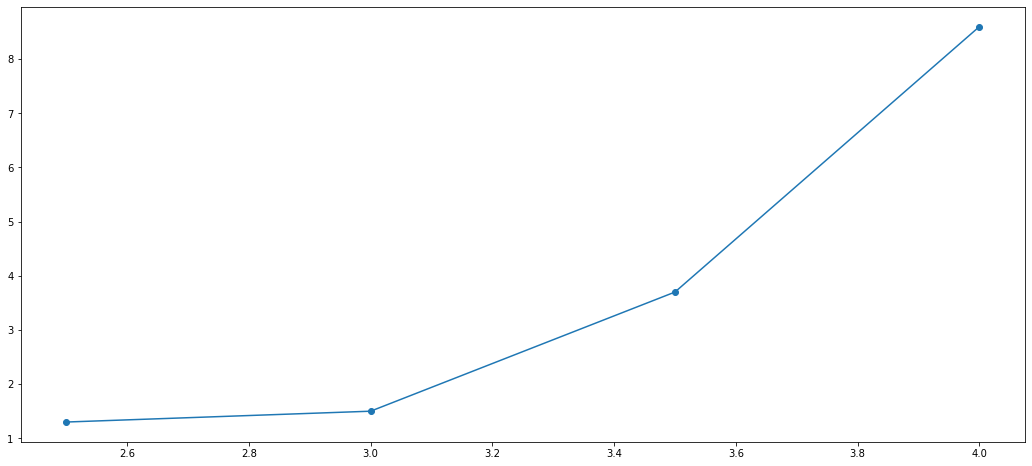

In [15]:
plt.plot(dfsub.stage, dfsub.lactate,'-o') # input: x and y, line style: '-o' = line + scatter

<AxesSubplot:xlabel='Stage [m/s]', ylabel='Lactate [mmol/l]'>

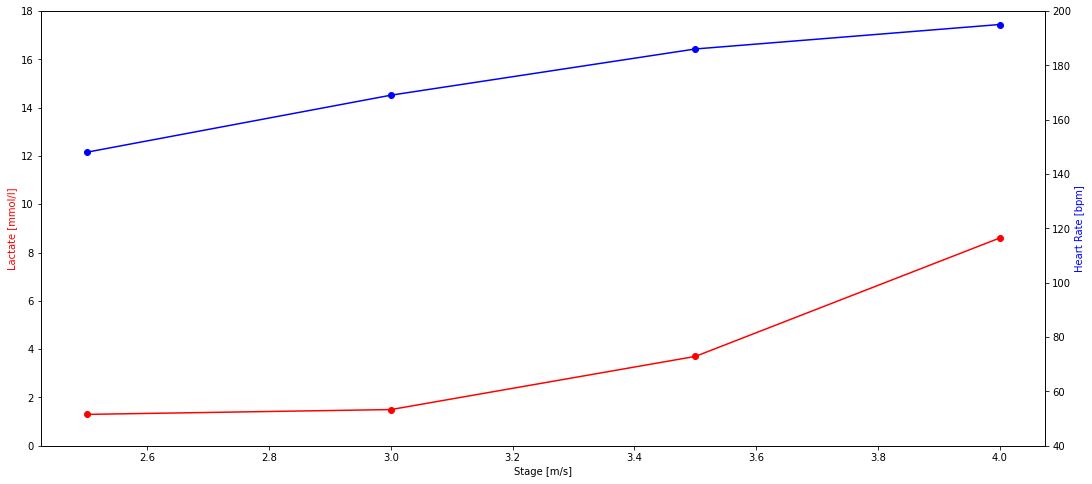

In [16]:
plot_increment(dfsub.stage, dfsub.lactate,dfsub.HR)

### Training Zones
We use the formula just as above to derive our training zones:

In [19]:
vZ=np.interp([2, 4], dfsub.lactate, dfsub.stage)
HRZ= np.interp([2, 4], dfsub.lactate, dfsub.HR)
HRZ

array([172.86363636, 186.55102041])

## Iterate over all data sets
We can access all individual data sets in a for-loop. To do so, we create a variable that contains all names from the data source and iterate over that. Let us create each individual's lactate curve this way:
### Plot all lactate curves

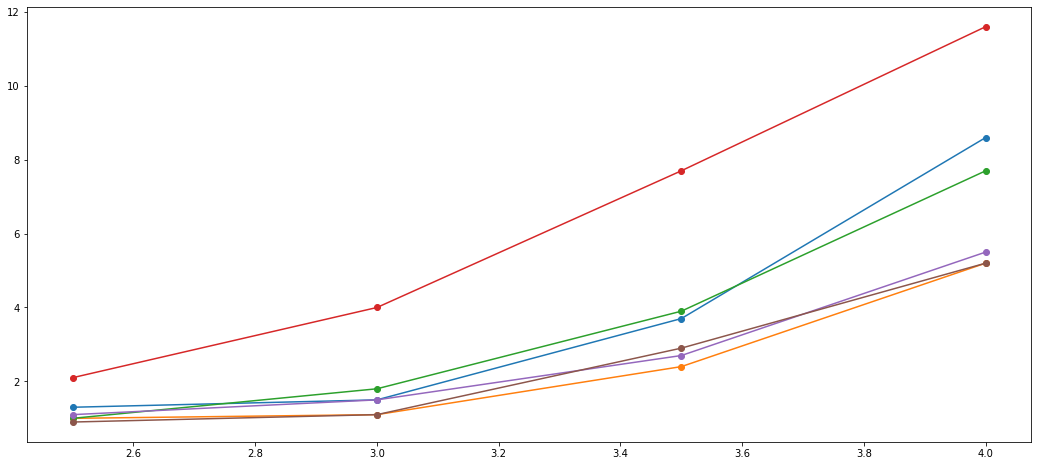

In [20]:
names=pd.unique(df.name)           # contains all names once
for name in names:
    dfsub=df[df.name == name]      # Name contains in each iteration the next value from Names
    plt.plot(dfsub.stage,dfsub.lactate,'-o')

<a id="i_linear_int"></a>
### Training Zones
In the same way, we can gather the training zone threshold for every subject. We store our results in a *dictionary* we call `D`.

In [21]:
D = dict()
for name in names:
    dfsub=df[df.name == name] 
    D[name] = {"vZ": np.interp([2, 4], dfsub.lactate, dfsub.stage), 
               "HRZ": np.interp([2, 4], dfsub.lactate, dfsub.HR)}

Here are some examples, how to access the data in a dictionary:

In [23]:
D['Paul']
D['Paul']['vZ']

array([3.11363636, 3.53061224])

<a id="Advanced"></a>
# Third Example: Advanced
Linear interpolation is not the only way to derive training zones based on fixed threshold. It is possible to fit a curve (eg, polynomial, exponential) to the data and take points on the fitted curve. We can possibly alleviate small measurement errors by using the best fit to our data. In fact, other methods which do not rely on fixed threshold often use those regression lines to calculate lactate thresholds. Thus, by learning about curve fits we open the door gate to advanced concepts step by step. Let´s import another package we are going to use:

In [24]:
from scipy import optimize   # curve fitting

## load data

In [25]:
dfsub=df[df.name == "Paul"]

## Fit a cubic curve
Physiologically resonable lactate curve forms are based on a cubic (third order polynomial) or exponential formula. We are going to start with the cubic formula which has the form:

$$ lactate = a + bv + cv^2 + dv^3 $$

We use simple linear regression using OLS (ordinary least squares) to find the best fitting line (ie, that minimizes the squared residuals). The resulting curve is based on the coefficients $ a,b,c,d $ - this is what we get from our regression model.



In [26]:
coef=np.polyfit(dfsub.stage,dfsub.lactate,3)
print(f'lactate = '  
      f'{round(coef[3],1)} + ' 
      f'{round(coef[2],1)} v + '
      f'{round(coef[1],1)} v² + '
      f'{round(coef[0],1)} v³')

lactate = 5.8 + 3.4 v + -4.4 v² + 0.9 v³


We simulate x-values (velocity) to predict y-values (lactate) based on our obtained formula

In [27]:
v = np.arange(min(dfsub.stage), max(dfsub.stage) + 0.5, 0.01)
lac = coef[3] + coef[2]*v + coef[1]*v**2 + coef[0]*v**3

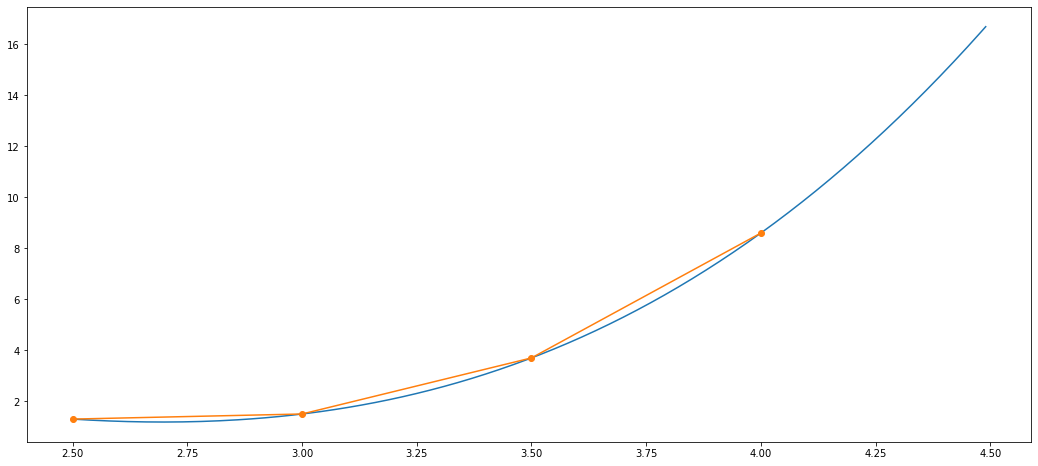

In [28]:
plt.plot(v,lac)
plt.plot(dfsub.stage,dfsub.lactate,'-o')

## Training Zones
To get our training zones analytically, we could solve the upper equation with our obtained coefficients by inserting our threshold and solve for v. Note, that a cubic formula could have up to 3 solutions. We could even fit an inverse model (switching lactate and velocity in the upper formula) whoch would ease the calculation a little bit. However, we just can save our effort and derive the solution numerically using our predicted values that are in a reasonable range. The smaller the steps in v, the more precise our estimates get.

In [29]:
np.interp([2, 4], lac, v)

array([3.17314343, 3.5422605 ])

<a id="a_exponential_fit_via_lm"></a>
## Fit an exponential curve
Both cubic and exponential curves can represent physiological features of the time-lactate curve in graded exercise. The cubic form allows a drop in lactate in the early stages compared to baseline, which can not be modelled with an exponential curve because it's slope is strict positive. This feature common in endurance athletes and can be explained by higher use of fatty acids. However, as you can see in the cubic model above, the predictions beyond our last data point fail. This is where the exponential fitting could provide better results. Let us see, if that is true!
The formula for our exponential model looks like this:

$$ lactate = a* e^{b*v} $$

<a id="a_exponential_fit_with_scipy"></a>
### exponential fit: scipy
Now we apply a different method - namely the `optimize.curve_fit()` function from the `scipy` package - to estimate these coefficients. This method is also applicable to the example before. First we need to define a function:

In [30]:
ExpFun = lambda v,a,b: a*np.exp(b*v)

Next, we pass this function and our data to `optimize.curve_fit()`

In [33]:
coef = optimize.curve_fit(ExpFun, dfsub.stage, dfsub.lactate,  p0=(1, 1))

a, b = coef[0]
print(a,b)

0.013836510628273808 1.6065182156232478


Note that we use the same velocity values as before, we just need to make new predictions based on our new model.

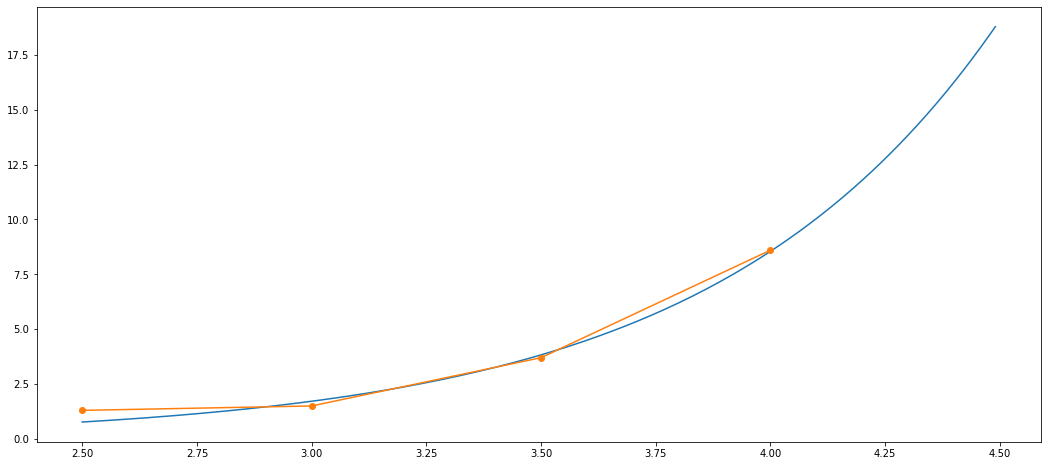

In [34]:
lac_exp = ExpFun(v,a,b)

plt.plot(v,lac_exp)
plt.plot(dfsub.stage,dfsub.lactate,'-o')

Again, the numerical solution is handy and valid:

In [35]:
np.interp([2, 4], lac_exp, v)

array([3.09586306, 3.5273261 ])

However, since there is only one solution, we show you how to obtain fixed values analytically:

$$
\begin{aligned}  
& &lactate & = a*e^{b*v}  \newline
&\iff &log(lactate) & = log (a*e^{b*v}) \newline 
&\iff &log(lactate) & = log(a) + log(e^{b*v})  \newline
&\iff &log(lactate) & = log(a) + b * v  \newline
&\iff &log(lactate) - log(a) & = b * v  \newline
&\iff &\frac{log(lactate) - log(a)}{b} & = v  \newline
\end{aligned}
$$


In [36]:
vFromExp = lambda L,a,b: (np.log(L)-np.log(a)) / b

vFromExp([2,4],a,b)

array([3.09588252, 3.52734179])

### exponential fit: linear model
It is possible to fit an exponential model by making it linear. For that, we have to apply a log-transformation like we just did to solve vor `v`. Note, that we reached in line 4 that equation:

$$ 
log(lactate) = log(a) + b * v
$$

This formula has the form $ f(x) = a + b *x $ with fixed coefficients $ a,b $. Thus, this is a straight line. We can fit this line with `np.polyfit` as this is a polynomonial equation first order ($x^1$). 

In [37]:
coef=np.polyfit(dfsub.stage,np.log(dfsub.lactate),1, w=np.sqrt(dfsub.lactate))

We plug our coefficients back in the exponential formula $ lactate = a*e^{b*v} $. By doing that, we have to exponentiate coefficient `a`:

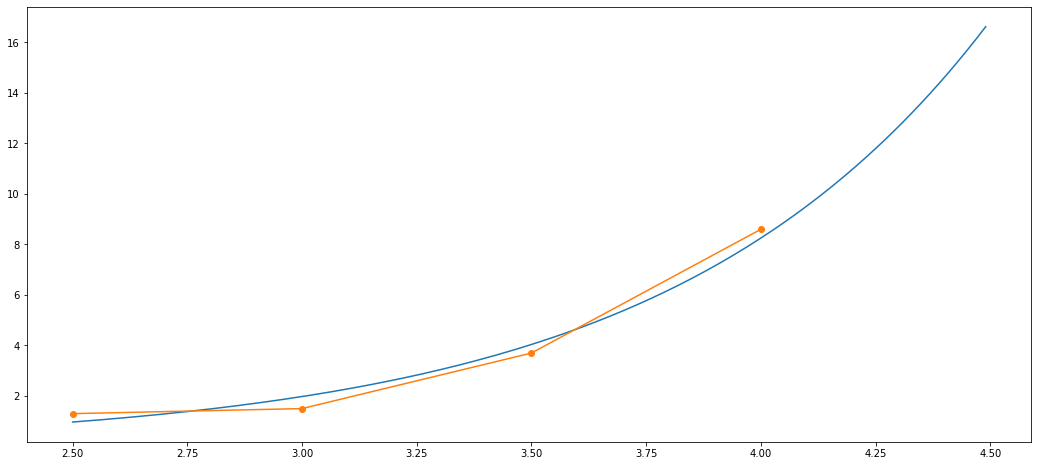

In [38]:
lac_poly = np.exp(coef[1]) * np.exp(coef[0]*v)

plt.plot(v,lac_poly)
plt.plot(dfsub.stage,dfsub.lactate,'-o')

Note, that both exponential models give slightly different predictions. This is due to that the error terms are handled either additively or multiplicatively (look here for more information: https://stackoverflow.com/questions/31851936/exponential-curve-fitting-in-r )

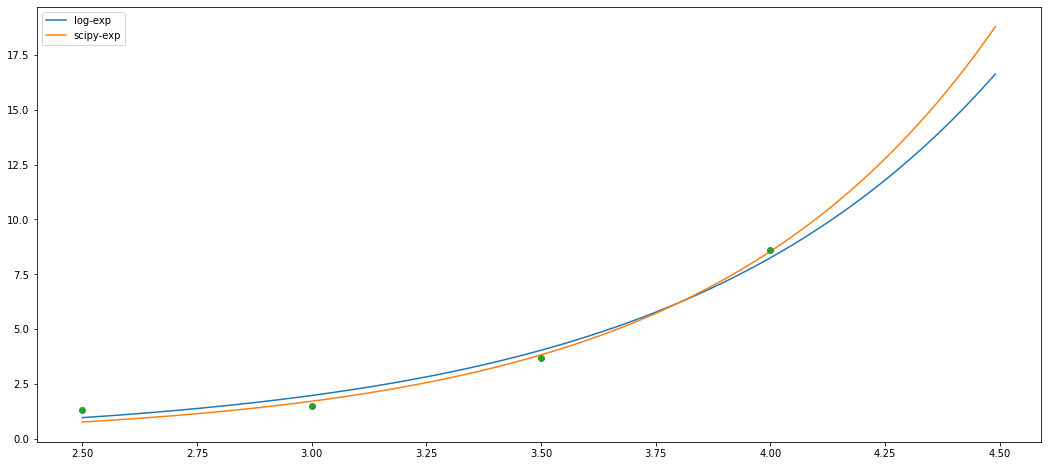

In [39]:
plt.plot(v,lac_poly)
plt.plot(v,lac_exp)
plt.plot(dfsub.stage,dfsub.lactate,'o')
plt.legend(['log-exp',
           'scipy-exp'])